In [4]:
import pandas as pd
file_path = 'src/df_cleaned.csv'
df = pd.read_csv(file_path)
df.head()

,Min Delay,Season,Day,Time Period,Station,Bound,Line,Min Gap,Issue Category
0,10,Winter,Monday,Night,KENNEDY BD STATION,E,BD,16,Other
1,4,Winter,Monday,Night,BLOOR STATION,N,YU,10,Miscellaneous & Passenger-Related Incidents
2,24,Winter,Monday,Night,FINCH STATION,S,YU,30,Other
3,6,Winter,Monday,Morning,EGLINTON STATION,N,YU,12,Human & Operational Factors
4,6,Winter,Monday,Morning,EGLINTON STATION,N,YU,12,Human & Operational Factors


In [2]:
df_cleaned = df

In [6]:
df_cleaned.info()
df_cleaned.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4731 entries, 0 to 4730
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Min Delay       4731 non-null   int64 
 1   Season          4731 non-null   object
 2   Day             4731 non-null   object
 3   Time Period     4731 non-null   object
 4   Station         4731 non-null   object
 5   Bound           4731 non-null   object
 6   Line            4731 non-null   object
 7   Min Gap         4731 non-null   int64 
 8   Issue Category  4731 non-null   object
dtypes: int64(2), object(7)
memory usage: 332.8+ KB


(4731, 9)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



# Encode categorical variables
categorical_features = ["Day", "Station", "Bound", "Line", "Season", "Time Period", "Issue Category"]
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])  # Convert categories to numerical values
    label_encoders[col] = le  # Store encoders for future use

# Define the target variable and predictor variables
X = df_cleaned.drop(columns=["Min Delay"])  # All variables except "Min Delay"
y = df_cleaned["Min Delay"]  # Target variable

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train the Random Forest Regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Display model performance metrics
print("Random Forest Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Random Forest Model Performance:
Mean Absolute Error (MAE): 0.71
Mean Squared Error (MSE): 3.71
Root Mean Squared Error (RMSE): 1.93
R² Score: 0.84


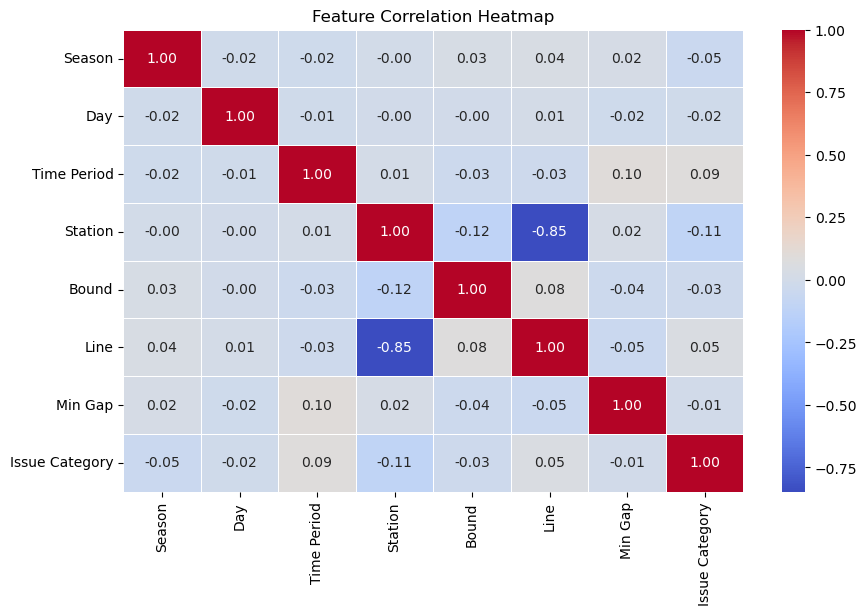

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = X_train.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


c:\Users\ufift\miniconda3\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 96%|=================== | 905/947 [00:16<00:00]       

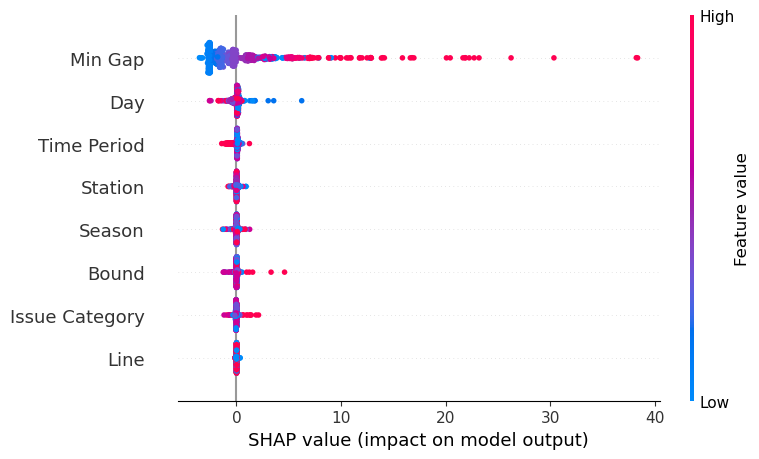

In [16]:
import shap

# Initialize SHAP explainer
explainer = shap.Explainer(rf_model, X_train)
shap_values = explainer(X_test)

# SHAP Summary Plot (Global Feature Impact)
shap.summary_plot(shap_values, X_test)


In [17]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Define model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=4)  # Select top 5 features
rfe.fit(X_train, y_train)

# Print selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['Season', 'Day', 'Bound', 'Min Gap'], dtype='object')


In [18]:
from sklearn.feature_selection import RFE

# Use RFE to select top features
rfe = RFE(estimator=rf, n_features_to_select=5)  # Adjust number of selected features
rfe.fit(X_train, y_train)

# Print selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)


Selected Features: Index(['Season', 'Day', 'Bound', 'Min Gap', 'Issue Category'], dtype='object')


In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Replace with best parameters found
best_params = grid_search.best_params_

# Train a new model with optimized hyperparameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_best = best_rf_model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred_best)
mse = mean_squared_error(y_test, y_pred_best)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_best)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")



Mean Absolute Error (MAE): 0.70
Mean Squared Error (MSE): 3.54
Root Mean Squared Error (RMSE): 1.88
R² Score: 0.85
